* Image denoising is to remove noise from a noisy image, so as to restore the true image
* In this notebook FER2013 dataset is used which contains approx 35 thousand images of 7 different emotions
* Image is grayscale of size 48*48

# Importing libraries

In [1]:
from keras.datasets import fashion_mnist, mnist
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model

import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd# Any results you write to the current directory are saved as output.
from IPython.display import display, Image

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

# Any results you write to the current directory are saved as output.
from IPython.display import display, Image

Using TensorFlow backend.


## Extract data from CSV

In [2]:
# get the data
filname = '../input/facial-expression/fer2013/fer2013.csv'

#different labels of images(not useful known about for current problem)
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

#different features names
names=['emotion','pixels','usage']

#Reading data in dataframe
df=pd.read_csv('../input/facial-expression/fer2013/fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


## Adding labels and images(pixel values) in respective array

In [3]:
#reading data and labels from dataset and appending in list

def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X), np.array(Y)
    return X, Y

In [4]:
#extracting data from dataset
X, Y = getData(filname)
num_class = len(set(Y))
#print(num_class)

## Reshaping images

In [5]:
# keras with tensorflow backend
N, D = X.shape

#reshaping the dataset
X = X.reshape(N, 48, 48, 1)

# Extracting Data and splitting train and test 

In [6]:
#splitting data in train, test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [7]:
#Taking 5000 images 

x_train = x_train[:5000]
x_test = x_test[:5000]

In [8]:
x_train.shape

(5000, 48, 48, 1)

# Data Preprocessing

In [9]:
#NOrmalizing the images
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

#reshaping the images
x_train = np.reshape(x_train, (len(x_train), 48, 48, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 48, 48, 1))  # adapt this if using `channels_first` image data format


#adding noise in data
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

#clipping put data near to 0--->0 aand data near to 1-->1(eg=0.3-->0 or 0.7-->1)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Visualization of 10 Data

In [10]:
n = 10

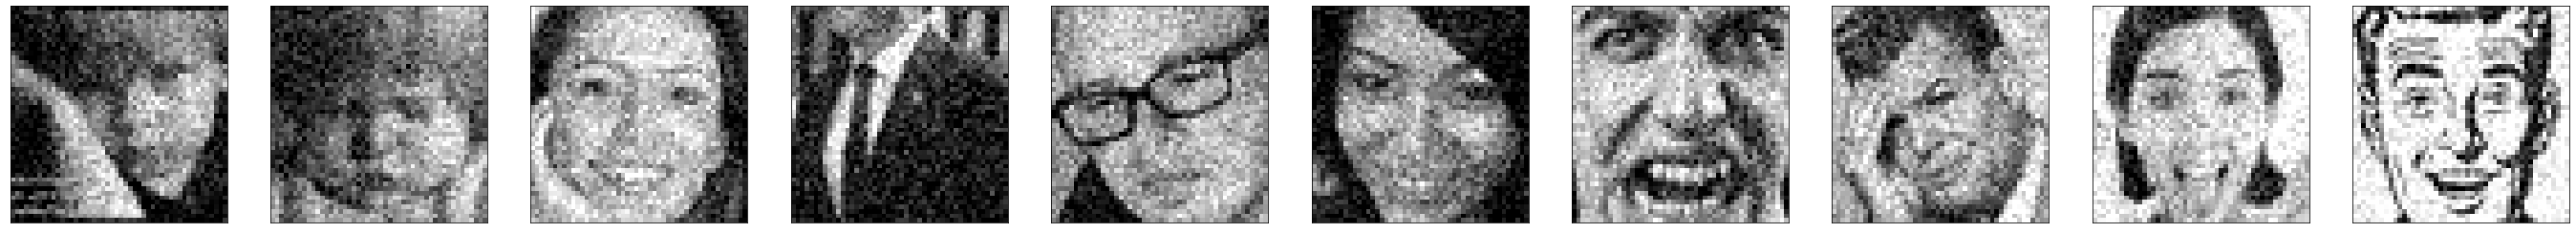

In [11]:
plt.figure(figsize=(48, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_train_noisy[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# One of the way we can achieve our goal of removing noise is AutoEncoder

**Copied from Keras Blog(https://blog.keras.io/building-autoencoders-in-keras.html):
**
* What are autoencoders good for?
* Today two interesting practical applications of autoencoders are data denoising (which we feature later in this post), and dimensionality reduction for data visualization. With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

**Refer to Keras Blog for better idea : https://blog.keras.io/building-autoencoders-in-keras.html**

## AutoEncoder Architecture

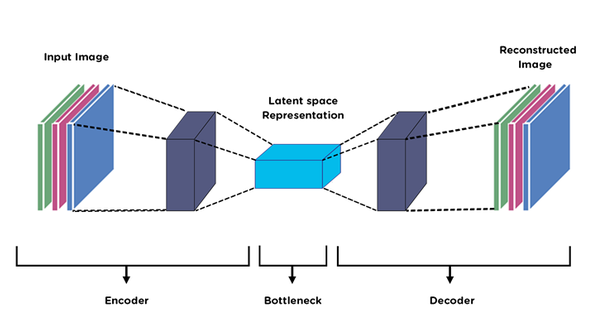

In [12]:
display(Image(filename="/kaggle/input/images-architecture/images_architecture/autoencoder.png"))

# Construction of Model

In [13]:
input_img = Input(shape=(48, 48, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.2)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Dropout(0.2)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='MSE')

# AutoEncoder Summary

In [14]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        9248

# Training Model

In [15]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=35,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Train on 5000 samples, validate on 5000 samples
Epoch 1/35
5000/5000 [==============================] - 5s 1ms/step - loss: 0.0267 - val_loss: 0.0128
Epoch 2/35
5000/5000 [==============================] - 1s 179us/step - loss: 0.0111 - val_loss: 0.0107
Epoch 3/35
5000/5000 [==============================] - 1s 195us/step - loss: 0.0084 - val_loss: 0.0086
Epoch 4/35
5000/5000 [==============================] - 1s 181us/step - loss: 0.0074 - val_loss: 0.0079
Epoch 5/35
5000/5000 [==============================] - 1s 180us/step - loss: 0.0068 - val_loss: 0.0068
Epoch 6/35
5000/5000 [==============================] - 1s 181us/step - loss: 0.0065 - val_loss: 0.0068
Epoch 7/35
5000/5000 [==============================] - 1s 183us/step - loss: 0.0062 - val_loss: 0.0057
Epoch 8/35
5000/5000 [==============================] - 1s 184us/step - loss: 0.0059 - val_loss: 0.0056
Epoch 9/35
5000/5000 [==============================] - 1s 187us/step - loss: 0.0057 - val_loss: 0.0053
Epoch 10/35
5000/5

## Making Prediction

In [16]:
predict = autoencoder.predict(x_test_noisy)

# Visualizing the prediction

## Original Test images

In [17]:
n=10

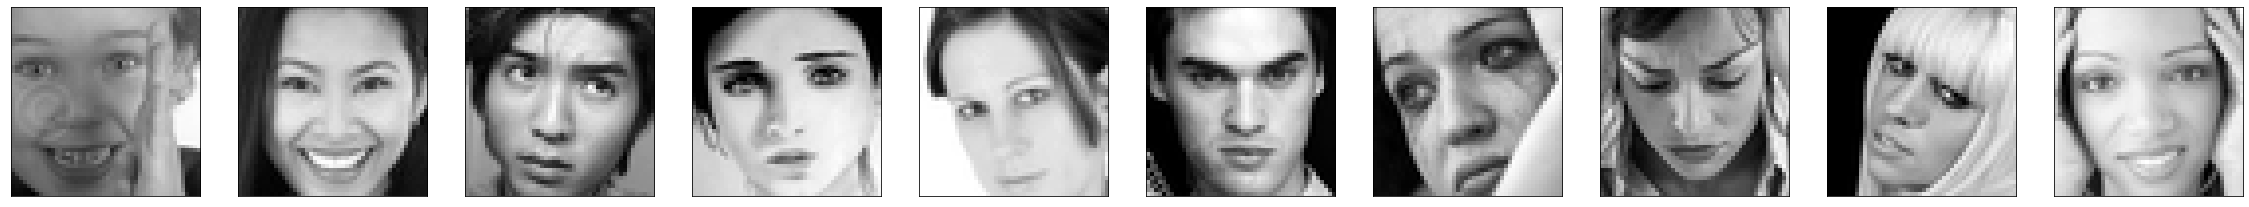

In [18]:
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Noised Test images

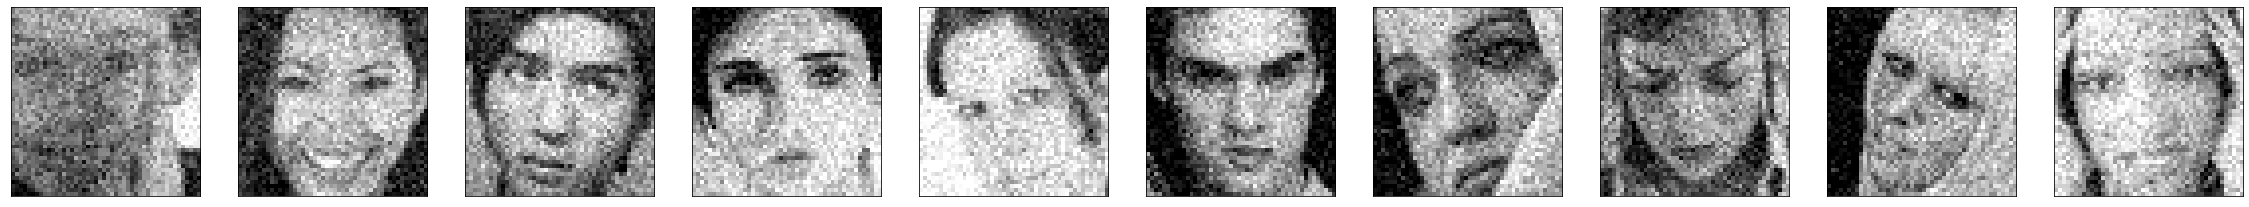

In [19]:
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Generated Test images

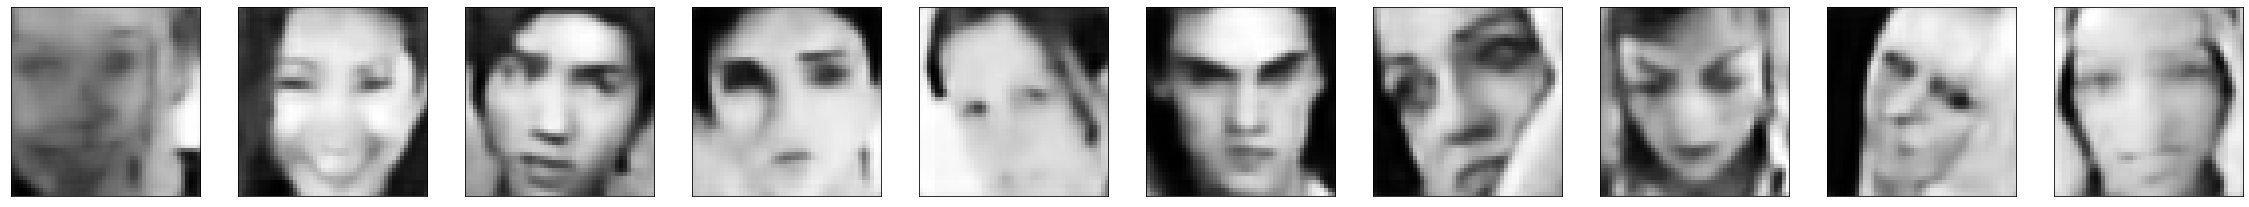

In [20]:
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(predict[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Not quite good. Lets try UNET

**Anwser taken from quora: https://www.quora.com/Why-is-U-Net-considered-as-an-autoencoder**

The classical auto-encoder architecture has the following property:
- First, it takes an input and reduces the receptive field of the input as it goes through the layers of its encoder units. Finally at the end of the encoder part of the architecture, the input is reduced to a linear feature representation.
- Next, the linear feature representation is upsampled (or its receptive field increased) by the decoder portion of the auto-encoder. So that at the other end of the autoencoder the result is of the same dimension as the input it received.
Such an architecture is ideal for preserving the dimensionality of input->output. But, the linear compression of the input leads to a bottleneck that does not transmit all features.

The U-Net has both the properties listed above, but it uses deconv units and overcomes the bottleneck limitation by adding skip connections that allow feature representations to pass through the bottleneck.

* Refer to original paper for better idea: https://arxiv.org/abs/1505.04597
* Implementation : https://towardsdatascience.com/u-net-b229b32b4a71

# UNET Structure

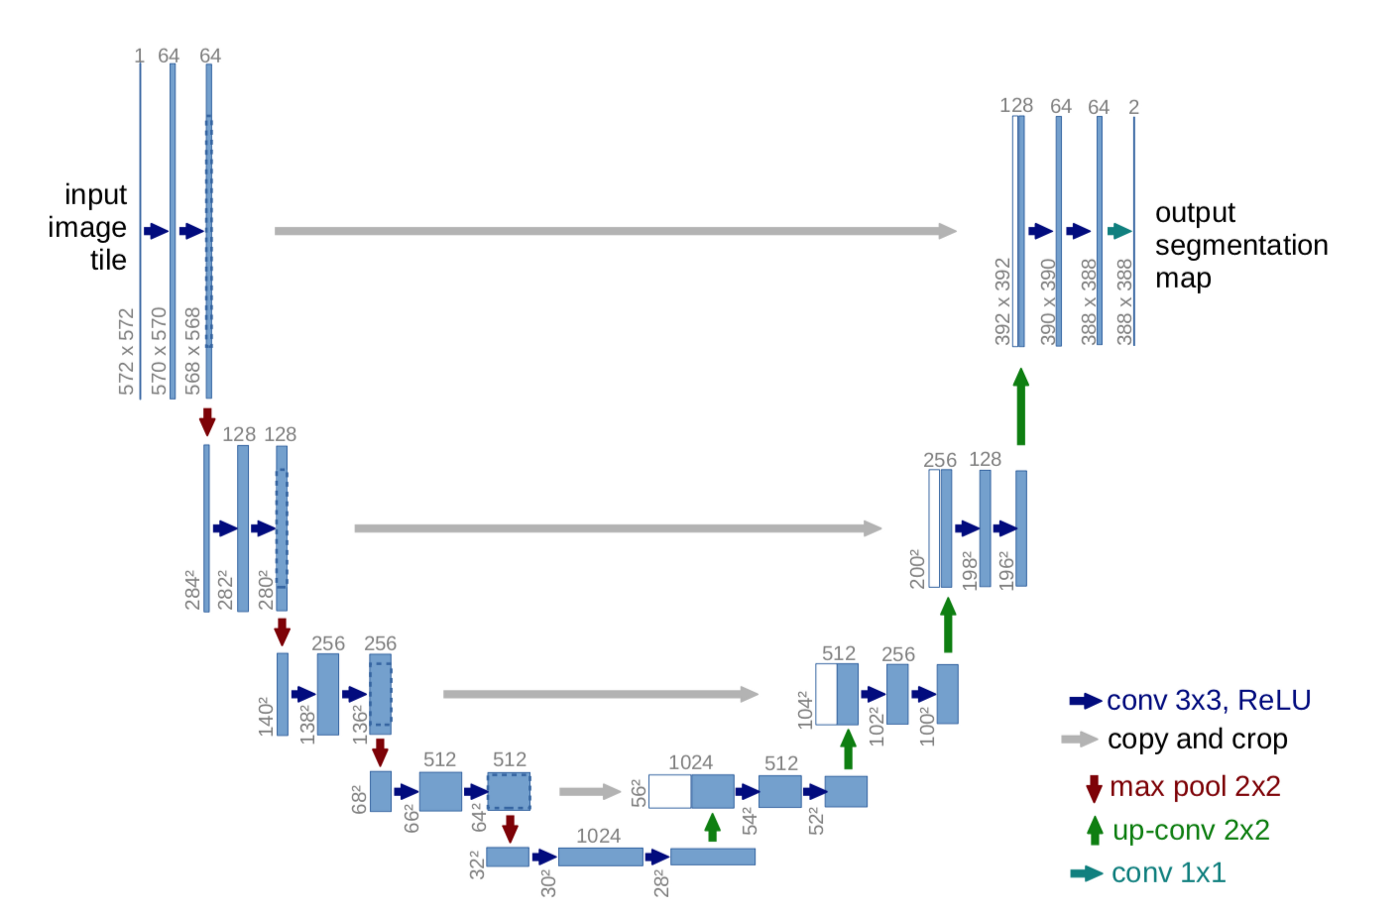

In [21]:
display(Image(filename="/kaggle/input/images-architecture/images_architecture/unet.png"))

# Construction of Model

In [22]:
def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons*1,(3,3), activation='relu', padding='same')(input_layer)
    conv1 = Conv2D(start_neurons*1,(3,3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)
    pool1 = Dropout(0.25)(pool1)
    
    conv2 = Conv2D(start_neurons*2,(3,3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(start_neurons*2,(3,3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons*4,(3,3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(start_neurons*4,(3,3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)
    pool3 = Dropout(0.5)(pool3)
    
    conv4 = Conv2D(start_neurons*8,(3,3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(start_neurons*8,(3,3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2,2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    #Middle
    convm = Conv2D(start_neurons * 16, (3,3), activation='relu', padding='same')(pool4)
    convm = Conv2D(start_neurons * 16, (3,3), activation='relu', padding='same')(convm)
    
    #upconv part
    deconv4 = Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons*8, (3,3), activation='relu', padding='same')(uconv4)
    uconv4 = Conv2D(start_neurons*8, (3,3), activation='relu', padding='same')(uconv4)
    
    deconv3 = Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons*4, (3,3), activation='relu', padding='same')(uconv3)
    uconv3 = Conv2D(start_neurons*4, (3,3), activation='relu', padding='same')(uconv3)
    
    deconv2 = Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons*2, (3,3), activation='relu', padding='same')(uconv2)
    uconv2 = Conv2D(start_neurons*2, (3,3), activation='relu', padding='same')(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons*1, (3,3), activation='relu', padding='same')(uconv1)
    uconv1 = Conv2D(start_neurons*1, (3,3), activation='relu', padding='same')(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding='same', activation='sigmoid')(uconv1)
    return output_layer

In [23]:
#Defining target image size and Input size and building model
img_size_target = 48
input_layer = Input((img_size_target, img_size_target,1))
output_layer = build_model(input_layer,64)

In [24]:
#Initializing and compiling model
model_unet = Model(input_layer, output_layer)
model_unet.compile(optimizer='adam', loss='MSE')

# UNET Summary

In [25]:
model_unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 48, 48, 64)   640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 48, 48, 64)   36928       conv2d_6[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 24, 24, 64)   0           conv2d_7[0][0]                   
____________________________________________________________________________________________

# Training Model

In [26]:
model_unet.fit(x_train_noisy, x_train,
                epochs=15,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Train on 5000 samples, validate on 5000 samples
Epoch 1/15
5000/5000 [==============================] - 23s 5ms/step - loss: 0.0155 - val_loss: 0.0037
Epoch 2/15
5000/5000 [==============================] - 20s 4ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 3/15
5000/5000 [==============================] - 20s 4ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 4/15
5000/5000 [==============================] - 20s 4ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 5/15
5000/5000 [==============================] - 20s 4ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 6/15
5000/5000 [==============================] - 20s 4ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 7/15
5000/5000 [==============================] - 20s 4ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 8/15
5000/5000 [==============================] - 20s 4ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 9/15
5000/5000 [==============================] - 20s 4ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 10/15
5000/5000 [==

# Making Prediction

In [27]:
predict = model_unet.predict(x_test_noisy)

# Visualizing the prediction

In [28]:
n=10

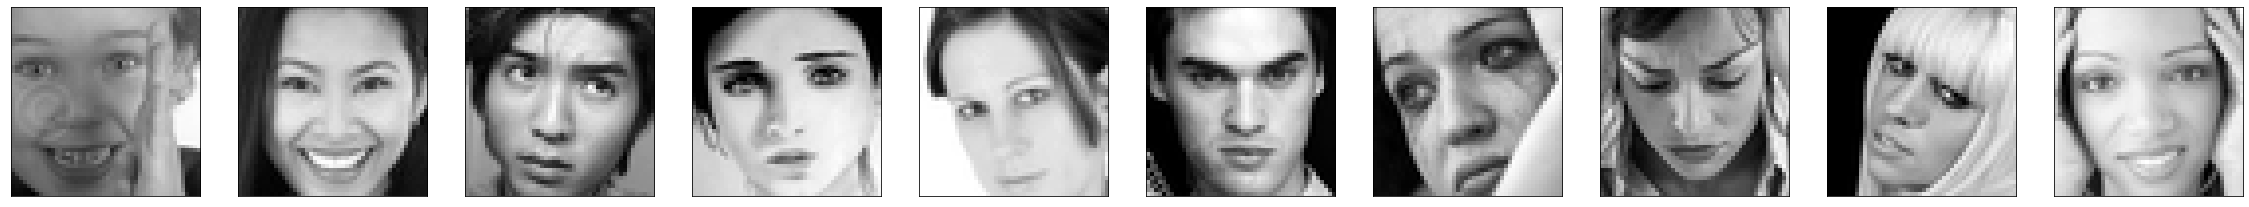

In [29]:
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Noised Test images

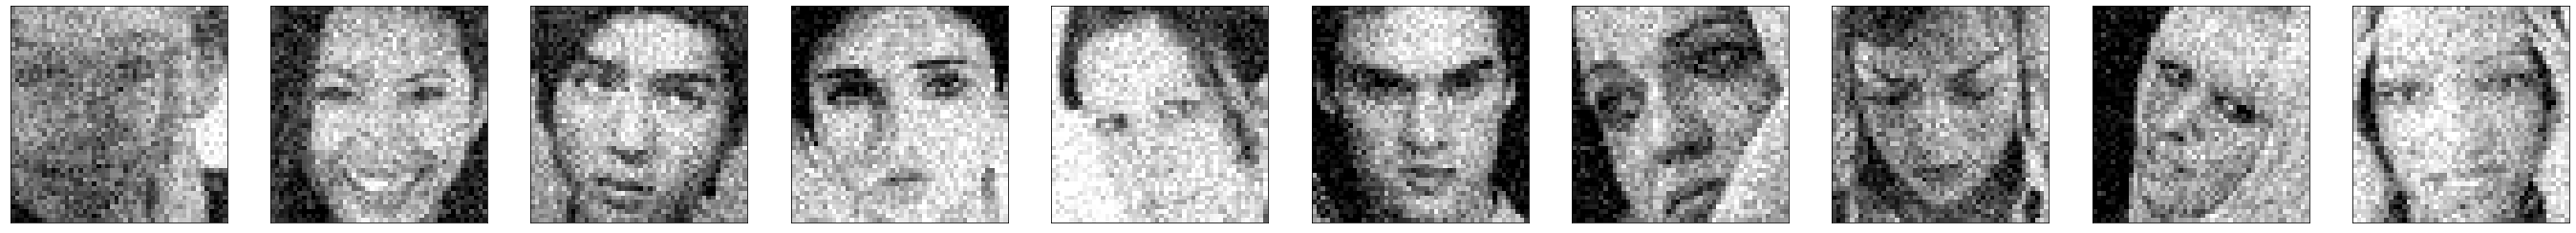

In [30]:
plt.figure(figsize=(48, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Generated Test images

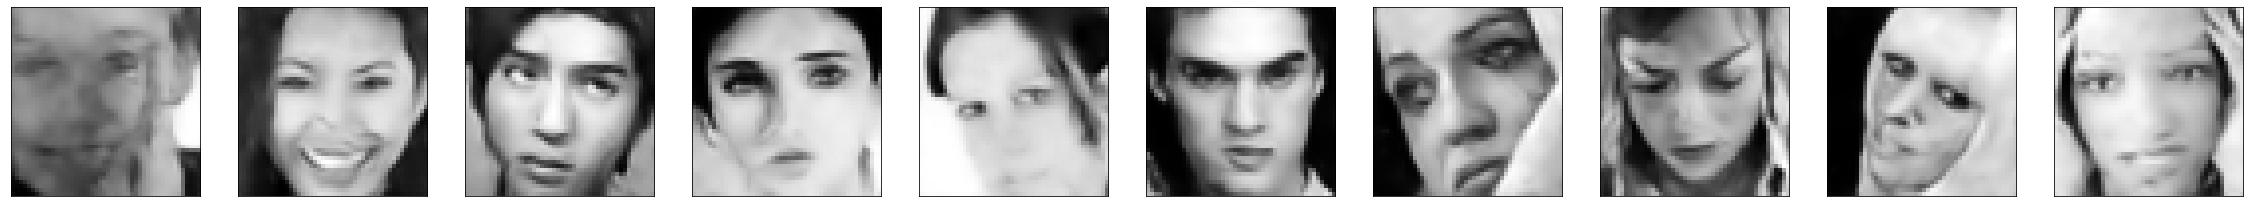

In [31]:
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(predict[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()